In [1]:
import pandas as pd
import numpy as np
import warnings
import math
warnings.filterwarnings("ignore")
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

## Store the Dataset into the Dataframe

In [2]:
df = pd.read_csv("electric_consumption.csv")

## Information

In [3]:
df.shape

(228166, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228166 entries, 0 to 228165
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   dt                     228166 non-null  object 
 1   Global_active_power    224434 non-null  float64
 2   Global_reactive_power  224434 non-null  float64
 3   Voltage                224434 non-null  float64
 4   Global_intensity       224434 non-null  float64
 5   Sub_metering_1         224434 non-null  float64
 6   Sub_metering_2         224433 non-null  float64
 7   Sub_metering_3         224433 non-null  float64
dtypes: float64(7), object(1)
memory usage: 13.9+ MB


In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,224434.000000,224434.000000,224434.000000,224434.000000,224434.000000,224433.000000,224433.000000
mean,1.308882,0.120900,239.702544,5.563506,1.276848,1.720692,6.311389
std,1.254631,0.111276,3.658699,5.298813,6.565552,6.929757,8.361744
min,0.104000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.312000,0.000000,237.150000,1.400000,0.000000,0.000000,0.000000
50%,0.924000,0.104000,240.020000,4.000000,0.000000,0.000000,0.000000
75%,1.880000,0.188000,242.320000,8.000000,0.000000,1.000000,17.000000
max,10.670000,0.988000,251.700000,46.400000,77.000000,78.000000,20.000000


## Data Preprocessing

In [6]:
df.head()

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Null values

In [7]:
df[df.isna().any(axis=1)]

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19725,2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41832,2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
194216,2007-04-30 14:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194217,2007-04-30 14:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194218,2007-04-30 14:22:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194219,2007-04-30 14:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.isnull().mean()*100

dt                       0.000000
Global_active_power      1.635651
Global_reactive_power    1.635651
Voltage                  1.635651
Global_intensity         1.635651
Sub_metering_1           1.635651
Sub_metering_2           1.636090
Sub_metering_3           1.636090
dtype: float64

In [9]:
# df.fillna(method='ffill', inplace=True)
df = df.dropna()

Dropped all the rows having null values.

In [10]:
df.isnull().mean()*100

dt                       0.0
Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64

### Duplicate Data

In [11]:
df[df.duplicated(keep=False)]

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3


No duplicate rows were found.

### Constant Column

In [12]:
df.nunique()

dt                       224433
Global_active_power        3622
Global_reactive_power       400
Voltage                    2353
Global_intensity            204
Sub_metering_1               73
Sub_metering_2               79
Sub_metering_3               21
dtype: int64

We don't have constant column. But, we have column 'dt' that have all values unique, which indicates that the feature is not important for our model. But before deleting this column, we will try to extract some usefull information from this feature.

### Quasi-Constant Column

In [13]:
quasi_features = get_constant_features(df, threshold=0.90, dropna=False)
quasi_features

,Desc,Var,Value,Perc
0,Quasi Constant,Sub_metering_1,0.0,91.508379


'Sub_metering_1' is the Quasi-Constant Column. But, we'll drop it after we have successfully captured the traget column.

In [14]:
quasi_list = quasi_features.query("Desc=='Quasi Constant'")['Var'].to_list()
quasi_list

['Sub_metering_1']


### Correlation Table

In [15]:
corr_matrix = df.corr().abs()
corr_matrix

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.276842,0.400044,0.999016,0.447294,0.450007,0.591465
Global_reactive_power,0.276842,1.000000,0.117158,0.290140,0.137566,0.175008,0.097029
Voltage,0.400044,0.117158,1.000000,0.410820,0.215826,0.177507,0.288598
Global_intensity,0.999016,0.290140,0.410820,1.000000,0.452397,0.455391,0.582042
Sub_metering_1,0.447294,0.137566,0.215826,0.452397,1.000000,0.070779,0.123625
Sub_metering_2,0.450007,0.175008,0.177507,0.455391,0.070779,1.000000,0.110616
Sub_metering_3,0.591465,0.097029,0.288598,0.582042,0.123625,0.110616,1.000000


Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements. So we are selecting the upper traingular.

In [16]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
upper_tri

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,NaN,0.276842,0.400044,0.999016,0.447294,0.450007,0.591465
Global_reactive_power,NaN,NaN,0.117158,0.290140,0.137566,0.175008,0.097029
Voltage,NaN,NaN,NaN,0.410820,0.215826,0.177507,0.288598
Global_intensity,NaN,NaN,NaN,NaN,0.452397,0.455391,0.582042
Sub_metering_1,NaN,NaN,NaN,NaN,NaN,0.070779,0.123625
Sub_metering_2,NaN,NaN,NaN,NaN,NaN,NaN,0.110616
Sub_metering_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Global_active_power' & 'Global_intensity' are highly correlated. We are selecting the columns which are having absolute correlation greater than 0.90 and making a list of those columns named 'high_corr'.

In [17]:
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
high_corr

['Global_intensity']

In [18]:
df.drop(high_corr, axis=1, inplace=True)

In [19]:
df.columns

Index(['dt', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

## Date Time Conversion


### Data Types for each column

In [20]:
df.dtypes

dt                        object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

### Converting the above column into "%Y%m%d" format

In [21]:
df['Date'] = pd.to_datetime(df['dt'], format = '%Y-%m-%d').dt.date
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

### Extracting Time

In [22]:
df['Time'] = pd.to_datetime(df['dt'], format = '%Y-%m-%d').dt.time
df['Time'] = pd.to_datetime(df['Time'], format = '%H:%M:%S')

### Extracting Year

In [23]:
df['Year'] = pd.to_datetime(df['dt'], format = '%Y-%m-%d').dt.year

In [24]:
def unique_dates(year):
    df_temp = df[df.Year==year]
    print(year,":",df_temp.Date.nunique())

In [25]:
unique_years = df.Year.unique()
for i in unique_years:
    unique_dates(i)

2006 : 16
2007 : 143


We can see, for the Year 2006, we only have the data for 16 days. Which will not help us understand the flow of data for that year. Thus we will drop the data for the Year 2006 and then analyse our data.

In [26]:
df = df[df.Year>2006]
df.reset_index(inplace = True, drop=True)
df.Year.unique()

array([2007], dtype=int64)

In [27]:
df.nunique()

dt                       202441
Global_active_power        3541
Global_reactive_power       396
Voltage                    2241
Sub_metering_1               70
Sub_metering_2               79
Sub_metering_3               21
Date                        143
Time                       1440
Year                          1
dtype: int64

Now, since we have captured date from the column 'dt'. We can drop this column.

In [28]:
df.drop('dt', axis=1, inplace=True)

Column 'dt' was dropped.

In [29]:
df.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Date                     datetime64[ns]
Time                     datetime64[ns]
Year                              int64
dtype: object

## Target Column

In [30]:
df['Consumed_active_energy'] = (df.Global_active_power*1000/60) - df.Sub_metering_1 - df.Sub_metering_2 - df.Sub_metering_3

In [31]:
print("Shape before dropping quasi constant features:",df.shape)
df.drop(quasi_list, inplace=True, axis=1)
print("Shape after dropping quasi constant features:",df.shape)

Shape before dropping quasi constant features: (202441, 10)
Shape after dropping quasi constant features: (202441, 9)


In [32]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year',
       'Consumed_active_energy'],
      dtype='object')

## Data Splitting

In [33]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_2,Sub_metering_3,Date,Time,Year,Consumed_active_energy
0,2.580,0.136,241.97,0.0,0.0,2007-01-01,1900-01-01 00:00:00,2007,43.000000
1,2.552,0.100,241.75,0.0,0.0,2007-01-01,1900-01-01 00:01:00,2007,42.533333
2,2.550,0.100,241.64,0.0,0.0,2007-01-01,1900-01-01 00:02:00,2007,42.500000
3,2.550,0.100,241.71,0.0,0.0,2007-01-01,1900-01-01 00:03:00,2007,42.500000
4,2.554,0.100,241.98,0.0,0.0,2007-01-01,1900-01-01 00:04:00,2007,42.566667


We will be splitting total data into train-test data,in the 70:30 ratio. Later, the train data will further be divided into train-cross-validation data 70:30 ratio.

### Train-Test Split:

In [34]:
X = df.iloc[:,:-1]
X.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year'],
      dtype='object')

In [35]:
y = df.iloc[:,-1:]
y.columns

Index(['Consumed_active_energy'], dtype='object')

In [36]:
X.shape, y.shape

((202441, 8), (202441, 1))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

* 70%: train data
* 30%: test data

#### Test Data

In [38]:
test = x_test.join(y_test)

In [39]:
test.shape

(60733, 9)

In [40]:
[x_test.shape,y_test.shape]

[(60733, 8), (60733, 1)]

#### Train Data

In [41]:
train = x_train.join(y_train)

In [42]:
train.shape

(141708, 9)

In [43]:
[x_train.shape,y_train.shape]

[(141708, 8), (141708, 1)]

### Train-Cross-Valiation Split:

In [44]:
X = train.iloc[:,:-1]
X.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year'],
      dtype='object')

In [45]:
y = train.iloc[:,-1:]
y.columns

Index(['Consumed_active_energy'], dtype='object')

In [46]:
X.shape, y.shape

((141708, 8), (141708, 1))

In [47]:
x_train, xcv, y_train, ycv = train_test_split(X, y, test_size=0.3, random_state=1)

#### Cross-Validation Data

In [48]:
[xcv.shape,ycv.shape]

[(42513, 8), (42513, 1)]

#### Train Data

In [49]:
train = x_train.join(y_train)

In [50]:
train.shape

(99195, 9)

In [51]:
[x_train.shape,y_train.shape]

[(99195, 8), (99195, 1)]

## Exploratory Data Analysis

In [52]:
df_date = train.groupby(['Date']).sum()

In [53]:
df_date.shape

(143, 7)

### Yearly

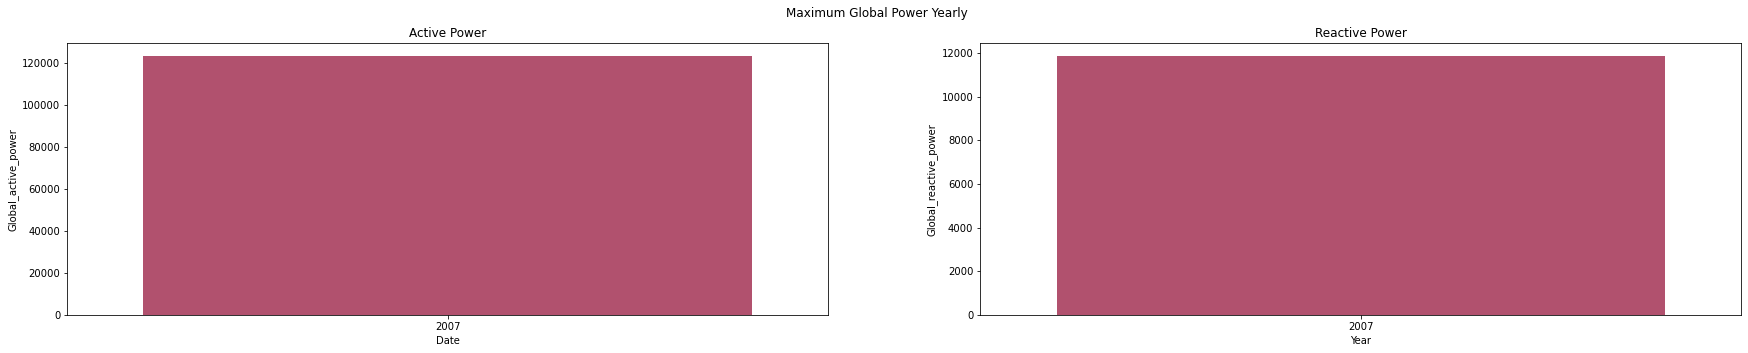

In [54]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30,5))
fig.suptitle("Maximum Global Power Yearly")

sns.barplot(ax=axes[0], y =df_date['Global_active_power'].groupby(df_date.index.year).sum(), x=df_date.index.year.unique(), palette='flare')
plt.xlabel("Year")
axes[0].set_title('Active Power')

sns.barplot(ax=axes[1], y =df_date['Global_reactive_power'].groupby(df_date.index.year).sum(), x=df_date.index.year.unique(), palette='flare')
axes[1].set_title('Reactive Power')
plt.xlabel("Year")

plt.show()

Both active and reactive power have been constant through out the years. There is no drastic change in these years.

### Quarterly

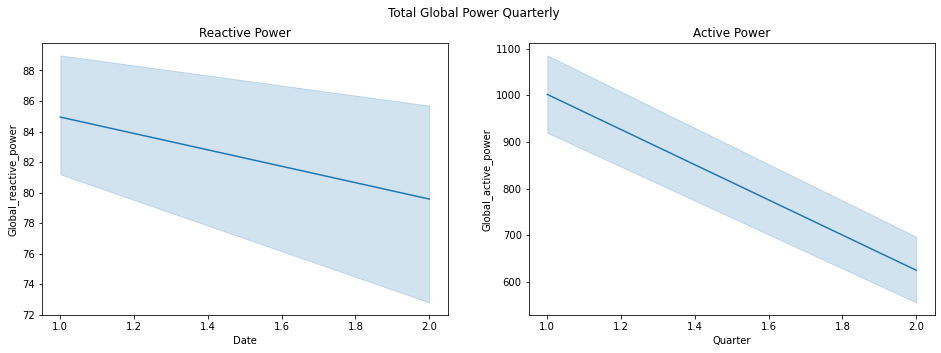

In [55]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))
fig.suptitle("Total Global Power Quarterly")

sns.lineplot(ax=axes[0], x=df_date.index.quarter, y="Global_reactive_power", data=df_date)
plt.xlabel("Quarter")
axes[0].set_title('Reactive Power')

sns.lineplot(ax=axes[1], x=df_date.index.quarter, y="Global_active_power", data=df_date)
plt.xlabel("Quarter")
axes[1].set_title('Active Power')

plt.show()

Reactive power is highest for the 3rd quarter. While Active power is lowest for the same quarter.

### Monthly

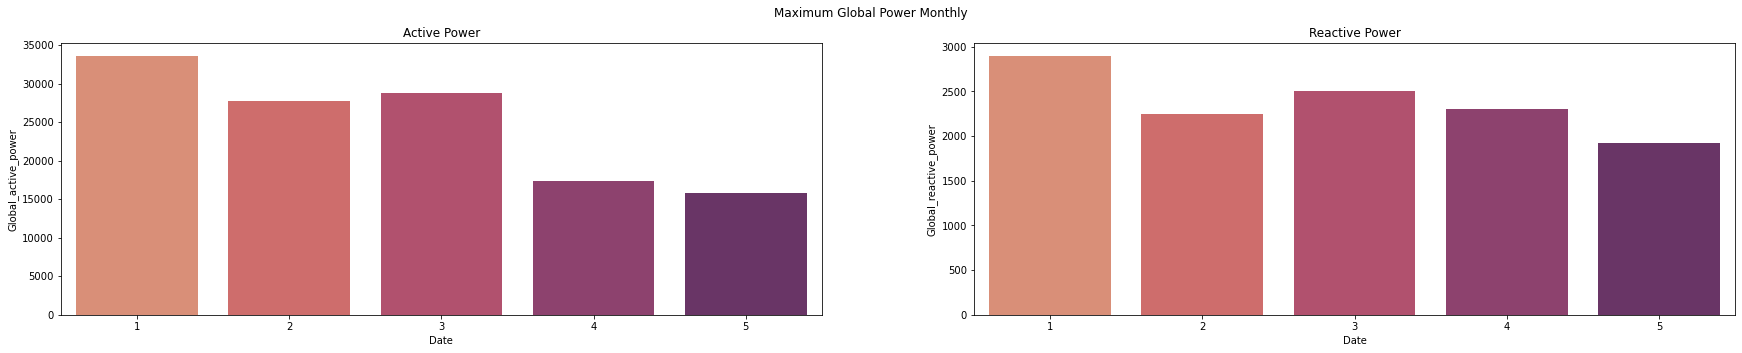

In [56]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(30,5))
fig.suptitle("Maximum Global Power Monthly")

sns.barplot(ax=axes[0], y =df_date['Global_active_power'].groupby(df_date.index.month).sum(), x=df_date.index.month.unique(), palette='flare')
axes[0].set_title('Active Power')

sns.barplot(ax=axes[1], y =df_date['Global_reactive_power'].groupby(df_date.index.month).sum(), x=df_date.index.month.unique(), palette='flare')
axes[1].set_title('Reactive Power')

plt.show()

For the months when the Active power decreases, Reactive power tends to increase.

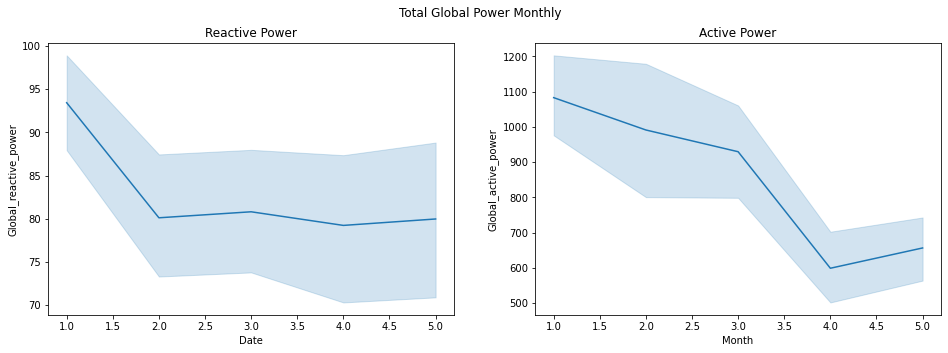

In [57]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))
fig.suptitle("Total Global Power Monthly")

sns.lineplot(ax=axes[0], x=df_date.index.month, y="Global_reactive_power", data=df_date)
plt.xlabel("Month")
axes[0].set_title('Reactive Power')

sns.lineplot(ax=axes[1], x=df_date.index.month, y="Global_active_power", data=df_date)
plt.xlabel("Month")
axes[1].set_title('Active Power')

plt.show()

Reactive power was maximum for the month of 'July', whereas Active power was maximum at the start/end of the year. 

## Feature Engineering 

In [58]:
train.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year',
       'Consumed_active_energy'],
      dtype='object')

### Detecting and Handling Outliers

Outliers will be detected and deleted from the training data only, because we want to train our model outlier free.

In [59]:
def remove_outliers_using_quantiles(qu_dataset, qu_field, qu_fence):
    a = qu_dataset[qu_field].describe()
    
    iqr = a["75%"] - a["25%"]
    print("Interquartile Range:", iqr)
    
    upper_inner_fence = a["75%"] + 1.5 * iqr
    lower_inner_fence = a["25%"] - 1.5 * iqr
    print("Upper Limit:", upper_inner_fence)
    print("Lower Limit", lower_inner_fence)
    
    upper_outer_fence = a["75%"] + 3 * iqr
    lower_outer_fence = a["25%"] - 3 * iqr
    print("Upper Limit:", upper_outer_fence)
    print("Lower Limit:", lower_outer_fence)
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_inner_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_inner_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("Percentage of records out of inner limit: %.2f"% (percentage))
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_outer_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_outer_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("Percentage of records out of outer limit: %.2f"% (percentage))
    
    if qu_fence == "inner":
        output_dataset = qu_dataset[qu_dataset[qu_field]<=upper_inner_fence]
        output_dataset = output_dataset[output_dataset[qu_field]>=lower_inner_fence]
    elif qu_fence == "outer":
        output_dataset = qu_dataset[qu_dataset[qu_field]<=upper_outer_fence]
        output_dataset = output_dataset[output_dataset[qu_field]>=lower_outer_fence]
    else:
        output_dataset = qu_dataset
    
    print("Length of Input Dataframe:", len(qu_dataset))
    print("Length of New Dataframe after Outlier Removal:", len(output_dataset))
    
    return output_dataset

In [60]:
train.dropna(inplace=True)
new_dataset = remove_outliers_using_quantiles(train, "Consumed_active_energy", "inner")

Interquartile Range: 9.299999999999997
Upper Limit: 27.483333333333327
Lower Limit -9.716666666666661
Upper Limit: 41.43333333333332
Lower Limit: -23.666666666666657
Percentage of records out of inner limit: 12.20
Percentage of records out of outer limit: 3.38
Length of Input Dataframe: 99195
Length of New Dataframe after Outlier Removal: 87095


In [61]:
train = new_dataset

In [62]:
train.shape

(87095, 9)

### Extract Quarter

In [63]:
train["Quarter"] = pd.to_datetime(train['Date'], format = '%Y-%m-%d').dt.quarter
x_train["Quarter"] = pd.to_datetime(x_train['Date'], format = '%Y-%m-%d').dt.quarter
x_test["Quarter"] = pd.to_datetime(x_test['Date'], format = '%Y-%m-%d').dt.quarter
xcv["Quarter"] = pd.to_datetime(xcv['Date'], format = '%Y-%m-%d').dt.quarter

### Extract Day:

In [64]:
train["Day"] = pd.to_datetime(train['Date'], format = '%Y-%m-%d').dt.day
x_train["Day"] = pd.to_datetime(x_train['Date'], format = '%Y-%m-%d').dt.day
x_test["Day"] = pd.to_datetime(x_test['Date'], format = '%Y-%m-%d').dt.day
xcv["Day"] = pd.to_datetime(xcv['Date'], format = '%Y-%m-%d').dt.day

### Extract Week:

In [65]:
train["Week"] = pd.to_datetime(train['Date'], format = '%Y-%m-%d').dt.week
x_train["Week"] = pd.to_datetime(x_train['Date'], format = '%Y-%m-%d').dt.week
x_test["Week"] = pd.to_datetime(x_test['Date'], format = '%Y-%m-%d').dt.week
xcv["Week"] = pd.to_datetime(xcv['Date'], format = '%Y-%m-%d').dt.week

### Extract Month:

In [66]:
train["Month"] = pd.to_datetime(train['Date'], format = '%Y-%m-%d').dt.month
x_train["Month"] = pd.to_datetime(x_train['Date'], format = '%Y-%m-%d').dt.month
x_test["Month"] = pd.to_datetime(x_test['Date'], format = '%Y-%m-%d').dt.month
xcv["Month"] = pd.to_datetime(xcv['Date'], format = '%Y-%m-%d').dt.month

### Extract Hour:

In [67]:
train["Hour"] = pd.to_datetime(train['Time'], format = '%Y-%m-%d').dt.hour
x_train["Hour"] = pd.to_datetime(x_train['Time'], format = '%Y-%m-%d').dt.hour
x_test["Hour"] = pd.to_datetime(x_test['Time'], format = '%Y-%m-%d').dt.hour
xcv["Hour"] = pd.to_datetime(xcv['Time'], format = '%Y-%m-%d').dt.hour

### Extract Minute:

In [68]:
train["Minute"] = pd.to_datetime(train['Time'], format = '%Y-%m-%d').dt.minute
x_train["Minute"] = pd.to_datetime(x_train['Time'], format = '%Y-%m-%d').dt.minute
x_test["Minute"] = pd.to_datetime(x_test['Time'], format = '%Y-%m-%d').dt.minute
xcv["Minute"] = pd.to_datetime(xcv['Time'], format = '%Y-%m-%d').dt.minute

### Sub_Metering_Sum:

In [69]:
train['Sub_Metering_Sum'] = train['Sub_metering_2'] + train['Sub_metering_3']
x_train['Sub_Metering_Sum'] =  x_train['Sub_metering_2'] + x_train['Sub_metering_3']
x_test['Sub_Metering_Sum'] = x_test['Sub_metering_2'] + x_test['Sub_metering_3']
xcv['Sub_Metering_Sum'] = xcv['Sub_metering_2'] + xcv['Sub_metering_3']

### Column Name

In [70]:
col = list(train.columns)
col.remove('Consumed_active_energy')
col.append('Consumed_active_energy')
col

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Sub_metering_2',
 'Sub_metering_3',
 'Date',
 'Time',
 'Year',
 'Quarter',
 'Day',
 'Week',
 'Month',
 'Hour',
 'Minute',
 'Sub_Metering_Sum',
 'Consumed_active_energy']

In [71]:
train = train[col]
train.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year', 'Quarter',
       'Day', 'Week', 'Month', 'Hour', 'Minute', 'Sub_Metering_Sum',
       'Consumed_active_energy'],
      dtype='object')

## Feature Selection

In [72]:
train.isnull().any()

Global_active_power       False
Global_reactive_power     False
Voltage                   False
Sub_metering_2            False
Sub_metering_3            False
Date                      False
Time                      False
Year                      False
Quarter                   False
Day                       False
Week                      False
Month                     False
Hour                      False
Minute                    False
Sub_Metering_Sum          False
Consumed_active_energy    False
dtype: bool

### Heat Map

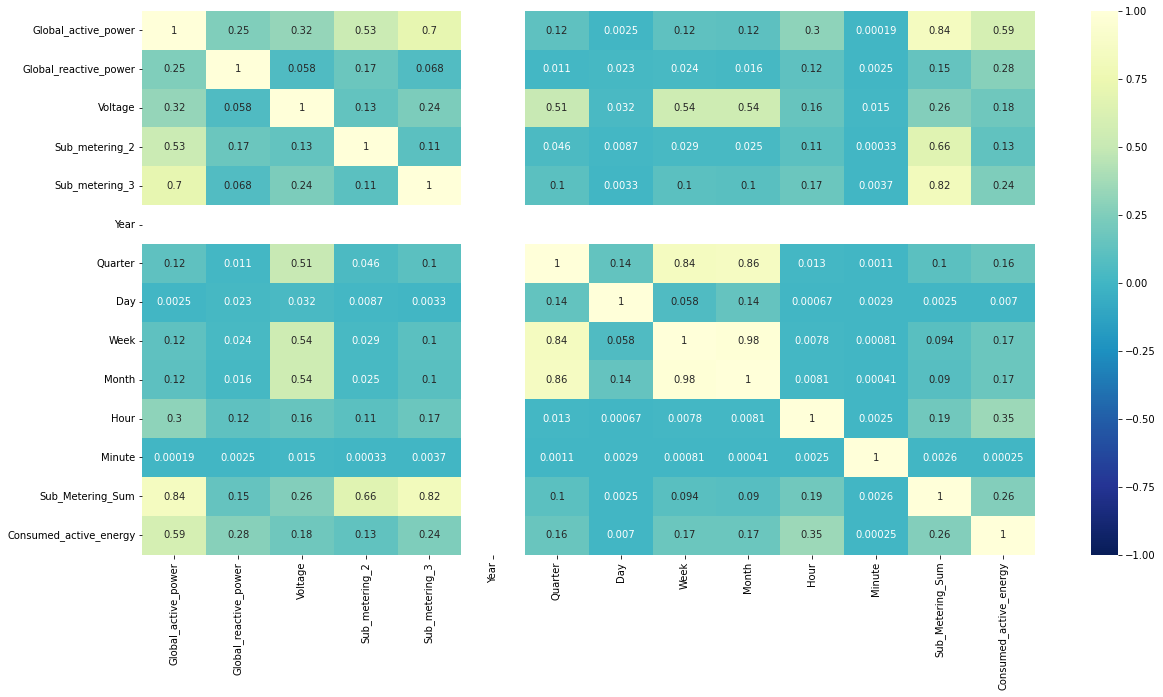

In [73]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr().abs(),annot=True,cmap="YlGnBu_r", vmin=-1,vmax=1)
plt.show()

In [74]:
x_train.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year', 'Quarter',
       'Day', 'Week', 'Month', 'Hour', 'Minute', 'Sub_Metering_Sum'],
      dtype='object')

In [75]:
xtrain = x_train[['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2', 'Sub_metering_3','Global_reactive_power']]
ytrain = y_train
xtrain.columns

Index(['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2',
       'Sub_metering_3', 'Global_reactive_power'],
      dtype='object')

In [76]:
xcv = xcv[['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2', 'Sub_metering_3','Global_reactive_power']]
xcv.columns

Index(['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2',
       'Sub_metering_3', 'Global_reactive_power'],
      dtype='object')

## Modeling

#### Now we need to compare with different ML models, and need to find out the best predicted model
* Linear Regression
* Decision Tree Regression
* Random Forest Regression
* XG Boost Regression

In [77]:
MSE_Score = []
MSE_Score_cv = []
MSE_Score_test = []
RMSE_Score = []
RMSE_Score_cv = []
RMSE_Score_test = []
Algorithm = []
R2_Score = []
R2_Score_cv = []
R2_Score_test = []

### Linear Regression

#### Model Training

In [78]:
Algorithm.append('LinearRegression')

regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

LinearRegression()

#### Training Data

In [79]:
predicted= regressor.predict(xtrain)
MSE_Score.append(mean_squared_error(ytrain, predicted))
mse = mean_squared_error(ytrain, predicted)
RMSE_Score.append(math.sqrt(mse))
R2_Score.append(r2_score(ytrain, predicted))

#### Cross-Validation Data

In [80]:
predicted_cv = regressor.predict(xcv)
MSE_Score_cv.append(mean_squared_error(ycv, predicted_cv))
mse = mean_squared_error(ycv, predicted_cv)
RMSE_Score_cv.append(math.sqrt(mse))
R2_Score_cv.append(r2_score(ycv, predicted_cv))

### Decision Tree Regression

In [81]:
Algorithm.append('DecisionTreeRegression')

regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(xtrain, ytrain)

DecisionTreeRegressor()

#### Training Data

In [82]:
predicted_dt= regressor_dt.predict(xtrain)
MSE_Score.append(mean_squared_error(ytrain, predicted_dt))
mse_dt = mean_squared_error(ytrain, predicted_dt)
RMSE_Score.append(math.sqrt(mse_dt))
R2_Score.append(r2_score(ytrain, predicted_dt))

#### Cross-Validation Data

In [83]:
predicted_dt_cv = regressor_dt.predict(xcv)
MSE_Score_cv.append(mean_squared_error(ycv, predicted_dt_cv))
mse_dt = mean_squared_error(ycv, predicted_dt_cv)
RMSE_Score_cv.append(math.sqrt(mse_dt))
R2_Score_cv.append(r2_score(ycv, predicted_dt_cv))

### XGBoost Regressor

In [84]:
Algorithm.append('XGB Regressor')

regressor_xg = xgb.XGBRegressor()
regressor_xg.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### Training Data

In [85]:
predicted_train = regressor_xg.predict(xtrain)
MSE_Score.append(mean_squared_error(ytrain, predicted_train))
mse_xg_train = mean_squared_error(ytrain, predicted_train)
RMSE_Score.append(math.sqrt(mse_xg_train))
R2_Score.append(r2_score(ytrain, predicted_train))

#### Cross-Validation Data

In [86]:
predicted_xg_cv = regressor_xg.predict(xcv)
MSE_Score_cv.append(mean_squared_error(ycv, predicted_xg_cv))
mse_xg_cv = mean_squared_error(ycv, predicted_xg_cv)
RMSE_Score_cv.append(math.sqrt(mse_xg_cv))
R2_Score_cv.append(r2_score(ycv, predicted_xg_cv))

## Comaprison Table

In [87]:
comp = pd.DataFrame(list(zip(Algorithm, RMSE_Score, RMSE_Score_cv, R2_Score, R2_Score_cv)), columns =['Algorithm', 'RMSE_Score_Train', 'RMSE_Score_cv', 'R2_Score_train', 'R2_Score_cv']) 
comp = comp.sort_values(by=['RMSE_Score_cv'])
comp.reset_index(inplace=True, drop=True)
comp.index = np.arange(1,len(comp)+1)
comp.head()

,Algorithm,RMSE_Score_Train,RMSE_Score_cv,R2_Score_train,R2_Score_cv
1,XGB Regressor,2.697397,3.561862,0.951089,0.916603
2,DecisionTreeRegression,0.002245,4.152194,1.000000,0.886668
3,LinearRegression,5.508429,5.523016,0.796025,0.799484


#### XGBoost Regressor has the lowest RMSE Score, and the highest R2 Score for the Cross-Validation Data. Therefore, we will proceed with XGBoost Regressor as our regression model. But, first we will perform Hyper Parameter Tuning.

## Hyper Parameter Tuning

In [88]:
# params = {
#     'n_estimators':[500],
#     'min_child_weight':[4,5], 
#     'gamma':[i/10.0 for i in range(3,6)],  
#     'subsample':[i/10.0 for i in range(6,11)],
#     'colsample_bytree':[i/10.0 for i in range(6,11)], 
#     'max_depth': [2,3,4,6,7],
#     'objective': ['reg:squarederror', 'reg:tweedie'],
#     'booster': ['gbtree', 'gblinear'],
#     'eval_metric': ['rmse'],
#     'eta': [i/10.0 for i in range(3,6)],
# }

# reg = xgb.XGBRegressor(nthread=-1)

# # run randomized search
# n_iter_search = 100
# random_search = RandomizedSearchCV(reg, param_distributions=params,n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

# start = time.time()
# random_search.fit(xtrain, ytrain)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time.time() - start), n_iter_search))


In [89]:
# best_regressor = random_search.best_estimator_
# best_regressor  

In [90]:
# Algorithm.append('XGB Regressor')

# regressor_xg = xgb.XGBRegressor(booster='gbtree', max_depth=7, min_child_weight=7, colsample_bytree=0.9, learning_rate=0.34, n_estimators=200)
# regressor_xg.fit(xtrain, ytrain)

In [91]:
# predicted = regressor_xg.predict(xtrain)
# MSE_Score.append(mean_squared_error(ytrain, predicted))
# mse_xg = mean_squared_error(ytrain, predicted)
# RMSE_Score.append(math.sqrt(mse_xg))
# R2_Score.append(r2_score(ytrain, predicted))

In [92]:
# predicted_xg_cv = regressor_xg.predict(xcv)
# MSE_Score_cv.append(mean_squared_error(ycv, predicted_xg_cv))
# mse_xg = mean_squared_error(ycv, predicted_xg_cv)
# RMSE_Score_cv.append(math.sqrt(mse_xg))
# R2_Score_cv.append(r2_score(ycv, predicted_xg_cv))

In [93]:
# comp = pd.DataFrame(list(zip(Algorithm, RMSE_Score, RMSE_Score_cv, R2_Score, R2_Score_cv)), columns =['Algorithm', 'RMSE_Score_Train', 'RMSE_Score_cv', 'R2_Score_train', 'R2_Score_cv']) 
# comp = comp.sort_values(by=['RMSE_Score_cv'])
# comp.reset_index(inplace=True, drop=True)
# comp.index = np.arange(1,len(comp)+1)
# comp.head(111)

## Test Data

In [94]:
x_test.shape

(60733, 15)

In [95]:
x_test.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_2', 'Sub_metering_3', 'Date', 'Time', 'Year', 'Quarter',
       'Day', 'Week', 'Month', 'Hour', 'Minute', 'Sub_Metering_Sum'],
      dtype='object')

### Feature Selection

In [96]:
xtest = x_test[['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2', 'Sub_metering_3','Global_reactive_power']]
ytest = y_test
xtest.columns

Index(['Global_active_power', 'Voltage', 'Hour', 'Sub_metering_2',
       'Sub_metering_3', 'Global_reactive_power'],
      dtype='object')

In [97]:
print(xtest.shape,ytest.shape)

(60733, 6) (60733, 1)


### Test Data Prediction

In [98]:
predicted_xg_test = regressor_xg.predict(xtest)
mse_xg_test = mean_squared_error(ytest, predicted_xg_test)
print("RMSE Test Data:",math.sqrt(mse_xg_test))
print("R2 Test Data:",r2_score(ytest, predicted_xg_test))

RMSE Test Data: 3.43310064678363
R2 Test Data: 0.9202554551806956
